#### Competition: https://www.kaggle.com/c/demand-forecasting-kernels-only

## LSTM model definition and training

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import path
import skimage.measure

import keras
from keras.models import Model
from keras.layers import Dense, Concatenate
from keras.layers import LSTM, Input
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [4]:
try:
    _file = project.get_file('adsc.etl.csv.1.csv')
except:
    _file = path.Path('adsc.etl.csv.1.csv')

In [5]:
dataset = pd.read_csv(_file).set_index('date')
dataset.head()

,store,item,sales,year,month,year-month,day-of-month,day-of-week,day-of-year
date,,,,,,,,,
2013-01-01,1,1,13,2013,1,2013-01,1,1,1
2013-01-01,7,12,26,2013,1,2013-01,1,1,1
2013-01-01,7,46,27,2013,1,2013-01,1,1,1
2013-01-01,8,12,54,2013,1,2013-01,1,1,1
2013-01-01,9,12,35,2013,1,2013-01,1,1,1


In [6]:
look_back = 20
predict_forward = 120

col = [i for i in dataset.columns if i not in ['year-month']]

features = [0, 1, 2, 3, 4, 5, 6, 7]
stores = [1]
items = [1]

def create_dataset(normal_set, scaler, predict_forward):
    dataX1, dataY = [], []
    for store in stores:
        for item in items:
            item_set = normal_set[(normal_set.store == store) & (normal_set.item == item)]
            for idx in range(0, len(item_set) - look_back - predict_forward):
                # dataX.append(train_set.iloc[idx-look_back:idx, 0:6].values)
                split_point = idx+look_back
                x_set = item_set.iloc[idx:split_point, :]
                y_set = item_set.iloc[split_point:split_point+predict_forward, :]
                x1 = scaler.transform(x_set.iloc[:, features].values)
                dataX1.append(x1)
                dataY.append(y_set.iloc[:, [2, 6]].values)
    return np.array(dataX1), np.array(dataY)# .reshape(-1, predict_forward)

num_features = len(features)

scaler = MinMaxScaler()
scaler.fit(dataset[col])


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X1, Y = create_dataset(
    dataset[col].sort_values(by=['store', 'item']), scaler, predict_forward)

display(X1.shape)
display(Y.shape)

(1686, 20, 8)

(1686, 120, 2)

In [7]:
train_X1, test_X1, train_Y, test_Y = train_test_split(X1, Y, test_size=0.1, random_state=42)

display(train_X1.shape)
display(test_X1.shape)
display(train_Y.shape)
display(test_Y.shape)

(1517, 20, 8)

(169, 20, 8)

(1517, 120, 2)

(169, 120, 2)

In [8]:
train_X1_reshaped = train_X1.reshape((-1, look_back, num_features))
test_X1_reshaped = test_X1.reshape((-1, look_back, num_features))

display(train_X1_reshaped.shape)

(1517, 20, 8)

### Model definiton

In [139]:
batch_size = 128
import tensorflow as tf

input_layer1 = Input(batch_shape=(batch_size, look_back, num_features))
lstm02 = LSTM(predict_forward, stateful=False, return_sequences=True, recurrent_activation='tanh')(input_layer1)
conv1 = keras.layers.Conv1D(kernel_size=3, filters=50, padding='valid')(lstm02)
pool1 = keras.layers.MaxPooling1D(18)(conv1)
dense1 = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(pool1)
lambda1 = keras.layers.Lambda(lambda x: tf.reshape(x, (batch_size, 50)))(pool1)
output_layer = Dense(predict_forward, activation=None)(lambda1)
model = Model(inputs=input_layer1, outputs=output_layer)
optimizer = keras.optimizers.Adagrad(clipnorm=1)
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=sgd, metrics=["mape"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (128, 20, 8)              0         
_________________________________________________________________
lstm_42 (LSTM)               (128, 20, 120)            61920     
_________________________________________________________________
conv1d_32 (Conv1D)           (128, 18, 50)             18050     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (128, 1, 50)              0         
_________________________________________________________________
lambda_16 (Lambda)           (128, 50)                 0         
_________________________________________________________________
dense_70 (Dense)             (128, 120)                6120      
Total params: 86,090
Trainable params: 86,090
Non-trainable params: 0
_________________________________________________________________


### Model training

In [143]:
epochs = 30
idx = int(len(train_X1_reshaped)/batch_size) * batch_size
hist = model.fit(
    train_X1_reshaped[:idx],
    train_Y[:idx, :, 0], # ['sales'].values.reshape(len(train_Y['sales']), 1)[:-1],
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    shuffle=True)

Epoch 1/30
1408/1408 [==============================] - 1s 755us/step - loss: 21.1171 - mean_absolute_percentage_error: 20.7065
Epoch 2/30
1408/1408 [==============================] - 1s 766us/step - loss: 22.5034 - mean_absolute_percentage_error: 21.5923
Epoch 3/30
1408/1408 [==============================] - 1s 719us/step - loss: 21.6956 - mean_absolute_percentage_error: 21.2699
Epoch 4/30
1408/1408 [==============================] - 1s 726us/step - loss: 20.7682 - mean_absolute_percentage_error: 20.7849
Epoch 5/30
1408/1408 [==============================] - 1s 656us/step - loss: 20.3688 - mean_absolute_percentage_error: 20.5787
Epoch 6/30
1408/1408 [==============================] - 1s 664us/step - loss: 20.6261 - mean_absolute_percentage_error: 20.7517
Epoch 7/30
1408/1408 [==============================] - 1s 670us/step - loss: 19.9411 - mean_absolute_percentage_error: 20.3201
Epoch 8/30
1408/1408 [==============================] - 1s 677us/step - loss: 19.5241 - mean_absolute_pe

### Model evaluation

In [144]:
# expected = test_Y # ['sales'].values.reshape(len(test_Y['sales']), 1)
test_idx = int(len(test_X1_reshaped)/batch_size) * batch_size
model.evaluate(test_X1_reshaped[:test_idx], test_Y[:test_idx, :, 0], batch_size=batch_size)

128/128 [==============================] - 0s 313us/step


[19.701377868652344, 19.4244384765625]

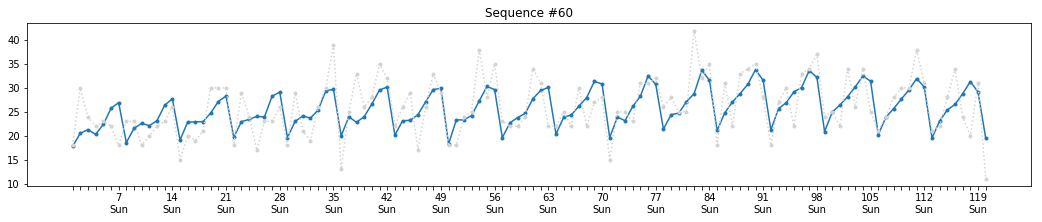

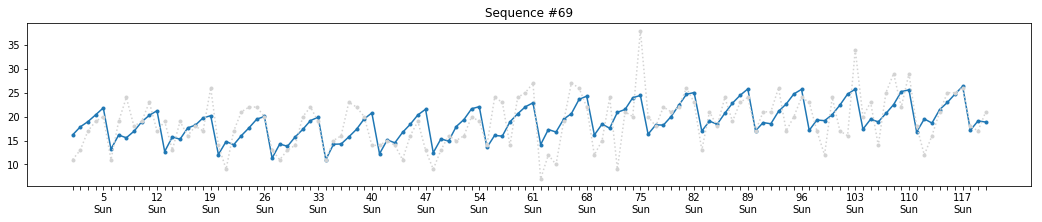

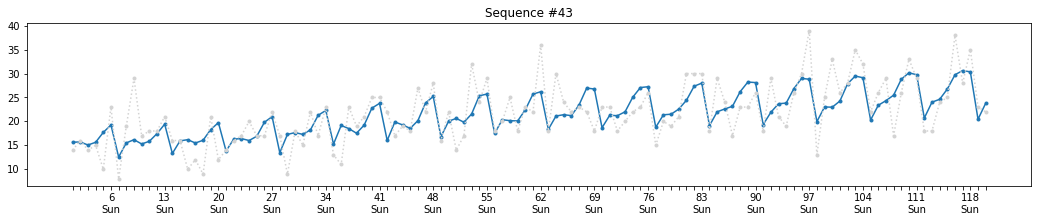

In [145]:
Yhat = model.predict(test_X1_reshaped[:test_idx], batch_size=batch_size)
# display(predicted.T[0], expected.T[0])
# inv_yhat = concatenate((predicted, test_X[:, 1:]), axis=1)
selection = np.random.randint(0, test_Y.shape[1], 3)

days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

for it in selection:
    plt.figure(figsize=(18, 3))
    plt.title("Sequence #%s" % it)
    plt.plot(Yhat[it], marker='.')
    labels = [''] * predict_forward
    for i, d in enumerate(test_Y[it, :, 1]):
        if d == 6:
            labels[i] = "%s\n%s" % (i+1, days[d])
    plt.xticks(range(len(test_Y[it, :, 0])), labels)
    plt.plot(test_Y[it, :, 0],  marker='.', linestyle=':', color='lightgray')

In [146]:
model.save('model.h5')

In [ ]:
from keras.models import load_model

file_name = 'adsc.lstm-model.v1.h5'
_file = project.get_file(file_name)
with open('model.h5', 'wb') as _dest:
    _dest.write(_file.read())

model = load_model('model.h5')